# Chapter 13: GPU-Accelerated Ising Model Simulation in NVIDIA Warp

![Example output](images/chapter-13/ising_animation.gif)


## Overview

In Chapter 12, we introduced NVIDIA Warp as a framework for writing high-performance GPU code in Python. We explored its fundamental concepts: the kernel-based programming model, data structures like arrays and built-in types, and the just-in-time compilation process that enables near-native performance.

In this chapter, we will apply these concepts to implement a classic statistical model for phase transition: the 2-D Ising model. This serves as an excellent case study for GPU acceleration because:

1. **Inherent parallelism**: Many lattice sites (subject to smart parallelism, more on this later!) can potentially be updated in parallel
2. **Memory access patterns**: Requires careful consideration of interactions with neighboring spins
3. **Real-World relevance**: The Ising model is fundamental in various fields, e.g., statistical physics, materials science, etc.

Through this implementation, you will learn:

* How to translate a sequential algorithm into a parallelized algorithm on GPU
* Common pitfalls when parallelizing algorithms with neighbor dependencies
* The checkerboard decomposition pattern for avoiding race conditions and reproducing accurate physics
* How to visualize and analyze simulation results using Python libraries

By the end of this chapter, you will have a GPU-accelerated 2-D Ising model simulation that runs $O(10)$ faster than its CPU counterpart, while gaining experience in applying NVIDIA Warp's features to solve a fundamental computational physics problems.

---


## Setup

Before we begin implementing the 2-D Ising model, let us ensure we have all the necessary packages installed.

First, we will install NVIDIA Warp if it is not already available:


In [ ]:
# Install NVIDIA Warp
%pip install warp-lang

# Install a few visualization dependencies
%pip install matplotlib ipympl Pillow

Now let us import the necessary libraries and initialize Warp to check if GPU support is available:


In [ ]:
# Core imports
import numpy as np
import warp as wp

# Check for GPU availability
if wp.get_cuda_device_count() > 0:
    print("✓ GPU detected successfully")
else:
    print("No GPU detected!")

---

## Introduction: From Warp fundamentals to real-world applications

In Chapter 12, we learned the essential building blocks of NVIDIA Warp.

Now, we will apply these concepts to implement the 2-D Ising model.

The Ising model is particularly instructive because it highlights both the power and challenges of GPU parallelization. While the algorithm seems embarrassingly parallel at a first glance (each lattice site can be updated independently), the devil is in the details — neighboring sites interact, creating potential race conditions that must be carefully managed.

Let us begin by understanding the physics behind the Ising model, then progressively build our GPU implementation, learning from common pitfalls along the way.

---

## Background: The Ising model in statistical physics

### What is the Ising model?

The [Ising model](https://en.wikipedia.org/wiki/Ising_model) serves as a framework for understanding **phase transitions** and **critical phenomena**. Named after physicist Ernst Ising, this model captures the essential physics of ferromagnetism while being simple enough to simulate and analyze computationally.

### Setup

Imagine a two-dimensional grid where each site contains a **magnetic spin** that can point either "up" (↑) or "down" (↓). In mathematical terms, each spin $\sigma_i$ takes the value $+1$ (up) or $-1$ (down). This seemingly simple setup gives rise to rich dynamics as temperature changes:

- At **low temperatures**: Spins tend to align with their neighbors, creating ordered regions
- At **high temperatures**: Thermal fluctuations dominate, leading to random, disordered spin configurations
- At the **critical temperature**: The system undergoes a phase transition

### How to calculate the energy of the system?

The total energy of the system is governed by the **Hamiltonian** $H$:

$$H(\sigma) = - J \sum_{ i \neq j} \sigma_i \sigma_j \tag{1}$$

Let us break this down:
- **$\sum_{ i \neq j} \sigma_i \sigma_j$**: Sum over all pairs of nearest neighbors (4 neighbors per site in 2-D)
- **$J > 0$**: Interaction strength (we will set $J = 1$ for simplicity)  
- **$\sigma_i \sigma_j$**: Product of neighboring spins

- When two neighboring spins are **aligned** ($\sigma_i = \sigma_j$): $\sigma_i \sigma_j = +1 \Rightarrow$ energy contribution is $-J$ (lower energy)
- When two neighboring spins are **anti-aligned** ($\sigma_i \neq \sigma_j$): $\sigma_i \sigma_j = -1 \Rightarrow$ energy contribution is $+J$ (higher energy)

This creates a tendency for spins to align with their neighbors at low temperatures. However, as temperature increases, configurations in which adjacent spins are of opposite signs become increasingly probable.  This is explained in more detail below.

### Competition between entropy maximization and energy minimization

The Ising model captures the interplay between two competing effects at the microscopic (lattice site) level:

1. **Energy minimization** (favoring aligned spins): Neighboring spins tend to align to minimize the Hamiltonian
2. **Entropy maximization** (favoring anti-aligned spins): Thermal fluctuations tend to randomize neighboring spin orientations

The **temperature** $T$ determines the macroscopic state of the system:
- **$T \ll T_c$**: Ordered state of lattice spins
- **$T \gg T_c$**: Disordered state of lattice spins  
- **$T \approx T_c$**: Transition from an ordered to a disordered state

### Metropolis-Hastings method for simulating the Ising model

To simulate this system computationally, we use the [**Metropolis-Hastings algorithm**](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) to sample configurations from the **Boltzmann distribution**:

$$P(\sigma) \propto e^{-H(\sigma)/(k_B T)} \tag{2}$$

#### Algorithm steps

Starting from an initial configuration, we iterate the following process:

1. **Selection**: Randomly choose a lattice site $i$
2. **Proposal**: Consider flipping the spin $\sigma_i \rightarrow -\sigma_i$
3. **Energy change**: Calculate $\Delta E =$ (energy after flip) - (energy before flip)
4. **Accept/reject decision**:
   - If $\Delta E \leq 0$: **Accept** the flip (lower energy is always favorable)
   - If $\Delta E > 0$: **Accept** with probability $P_{accept} = e^{-\Delta E/(k_B T)}$ (note that as $T \rightarrow \infty$, $P_{accept} \rightarrow 1$ and as $T \rightarrow 0$, $P_{accept} \rightarrow 0$)
5. **Update**: Apply the flip if accepted, otherwise keep the original spin

The acceptance probability $e^{-\Delta E/(k_B T)}$ ensures that:
- **Low temperatures**: Only energy-lowering moves are likely to be accepted since as $T \rightarrow 0$, $P_{accept} \rightarrow 0$
- **High temperatures**: Even energy-raising moves can have significant acceptance probability since as $T \rightarrow \infty$, $P_{accept} \rightarrow 1$

### Why should we care?

- **Sufficient complexity**: The Metropolis algorithm involves neighbor interactions and probabilistic updates that need to be taken care of while designing the algorithm
- **Parallelization challenges**: Naive parallelization leads to race conditions when updating neighboring spins in parallel
- **Validation**: The known analytical solution for the 2-D case without an external magnetic field provides a precise benchmark for validating computational results.

In the next sections, we will first implement a baseline model using single-threaded, pure Python on the CPU. We will then build an optimized, GPU-accelerated version in NVIDIA Warp, demonstrating a progressive path to a performant simulation that avoids race conditions and faithfully recovers the underlying physics.

---

## A basic Python implementation

Before diving into GPU acceleration with Warp, let us implement a reference sequential version in Python (not using Warp). This serves multiple purposes:

1. **Algorithm verification**: Ensures our understanding of the Metropolis-Hastings algorithm is correct
2. **Performance baseline**: Provides a comparison point for measuring GPU speedup
3. **Debugging reference**: A simpler implementation against which we can validate the parallelized implementation

### Implementation strategy

Our Python implementation follows the standard Metropolis-Hastings algorithm:

- **Random site selection**: Instead of scanning sites in order, we randomly shuffle the update sequence to avoid artifacts
- **Periodic boundary conditions**: The lattice wraps around at edges
- **Energy-based acceptance**: We use the full Boltzmann acceptance probability $P = e^{-\Delta E / T}$, setting $k_B = 1$

### Performance limitations

Since this is a pure Python implementation with nested loops and random number generation, we are restricted to relatively small lattice sizes ($\leq 512 \times 512$) for reasonable Monte Carlo (MC) steps ($200-500$ throughout this tutorial).

In [ ]:
import random
import math


def initialize_lattice(L):
    """
    Initialize a square lattice with random spin orientations.

    Creates an L×L grid where each site contains a magnetic spin that can be
    either +1 (spin up) or -1 (spin down). The initial configuration is
    random.

    Args:
        L (int): Linear size of the lattice (creates L×L grid)

    Returns:
        list[list[int]]: 2-D lattice where lattice[i][j] ∈ {-1, +1}
    """
    lattice = [[random.choice([-1, 1]) for _ in range(L)] for _ in range(L)]
    return lattice


def monte_carlo_step(lattice, L, T):
    """
    Perform one complete Monte Carlo step using the Metropolis-Hastings algorithm

    A Monte Carlo (MC) step consists of attempting to flip each spin in the
    lattice exactly once. We visit sites in random order to avoid
    systematic biases that could arise from sequential scanning.

    For each site, we calculate the energy change ΔE that would result from
    flipping the spin, then accept or reject the flip based on the Boltzmann
    probability

    Physical Parameters (using natural units):
        - J = 1: Interaction strength
        - k_B = 1: Boltzmann constant
        - Periodic boundary conditions

    Args:
        lattice (list[list[int]]): Current spin configuration to update in-place
        L (int): lattice size in terms of number of grid points along one dimension
        T (float): Temperature, T_critical ≈ 2.269 for 2-D Ising model when k_B = J = 1

    Algorithm Details:
        1. Create list of all (i,j) lattice coordinates
        2. Randomly shuffle the update order to avoid artifacts
        3. For each site (i,j):
           a. Calculate sum of 4 nearest neighbors using periodic boundaries
           b. Compute energy change: ΔE = 2 * J * σ_ij * Σ_neighbors
           c. Accept flip with probability P = exp(-ΔE/T)
           d. Update lattice[i][j] *= -1 if flip accepted

    Note:
        The acceptance ratio simplifies to exp(-2 * β * σ_ij * neighbor_sum)
        because we only consider the energy difference, not absolute energy.
    """
    # Convert temperature to inverse temperature (β = 1/T)
    # kB = 1
    beta = 1.0 / T

    # Generate all lattice coordinates and randomize update order
    # This prevents systematic artifacts from sequential scanning
    site_indices = [(r_idx, c_idx) for r_idx in range(L) for c_idx in range(L)]
    random.shuffle(site_indices)

    # Visit each site and attempt to flip its spin according to Metropolis acceptance criterion
    for i, j in site_indices:
        # Current spin at site (i,j)
        spin_ij = lattice[i][j]

        # Calculate sum of 4 nearest neighbors with periodic boundary conditions
        # Modulo arithmetic wraps around lattice edges: (i-1+L)%L and (i+1)%L handle this
        nn_sum = (
            lattice[(i - 1 + L) % L][j]  # neighbor above
            + lattice[(i + 1) % L][j]  # neighbor below
            + lattice[i][(j - 1 + L) % L]  # neighbor left
            + lattice[i][(j + 1) % L]  # neighbor right
        )

        # Energy change from flipping spin: ΔE = -J * (σ_new - σ_old) * Σ_neighbors
        # Since σ_new = -σ_old, we get: ΔE = 2 * J * σ_ij * Σ_neighbors
        # Acceptance probability: P = exp(-β * ΔE) = exp(-β * 2 * σ_ij * Σ_neighbors)
        acceptance_ratio = math.exp(-beta * 2 * spin_ij * nn_sum)

        # Accept flip if random number < acceptance probability
        if random.random() < acceptance_ratio:
            lattice[i][j] *= -1  # Flip the spin
        else:
            pass
        # If flip rejected, spin remains unchanged (no action needed)

#### Visualizing the evolution of the Ising model simulation for 200 Monte Carlo steps

In [ ]:
%matplotlib widget

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import IPython.display

import os
import time

# --- Simulation Parameters ---
LATTICE_SIZE = 256
TEMPERATURE = 0.02  # Try: T=0.02 (ordered), T=2.269 (critical), T=20.0 (disordered)

print(f"Simulating {LATTICE_SIZE}×{LATTICE_SIZE} Ising model at T={TEMPERATURE}")
print(
    f"Critical temperature T_c ≈ 2.269 (this run: {'below' if TEMPERATURE < 2.269 else 'above'} T_c)"
)

# Initialize with random spins (mimics infinite temperature initial condition)
lattice = initialize_lattice(LATTICE_SIZE)

# Set up visualization colormap
# Viridis colormap: dark blue (-1 spins) to bright yellow (+1 spins)
viridis = plt.cm.viridis
norm = Normalize(vmin=-1, vmax=1)

# Collect animation frames
frames = []
print("Running simulation and capturing frames...")

start_time = time.perf_counter()
for step in range(200):  # 200 Monte Carlo steps
    # Evolve the system by one complete lattice sweep
    monte_carlo_step(lattice, LATTICE_SIZE, TEMPERATURE)

    # Convert lattice to colored image for visualization
    # Each spin value (-1 or +1) gets mapped to a color
    colored_frame = viridis(norm(np.array(lattice)))

    # Convert to 8-bit RGB for GIF creation
    rgb_frame = (colored_frame[:, :, :3] * 255).astype(np.uint8)
    frames.append(rgb_frame)

    # Progress indicator
    if (step + 1) % 50 == 0:
        print(f"  Step {step + 1}/200 completed")

end_time = time.perf_counter()
print(f"Simulation completed in {end_time - start_time:.2f} seconds")

# Create animated GIF to visualize time evolution
print("Creating animated GIF...")
pil_images = [Image.fromarray(frame, mode="RGB") for frame in frames]
output_filename = f"./images/chapter-13/{LATTICE_SIZE}x{LATTICE_SIZE}_{TEMPERATURE}.gif"

# Ensure output directory exists
os.makedirs(os.path.dirname(output_filename), exist_ok=True)

# Save as animated GIF (100ms per frame = 10 FPS)
pil_images[0].save(
    output_filename,
    save_all=True,
    append_images=pil_images[1:],
    duration=100,  # milliseconds per frame
    loop=0,  # infinite loop
)

IPython.display.Image(output_filename)

####  Analyzing the change in the magnetization of the system as simulation evolves

Magnetization, defined as  $M = \sum_{i=1}^{N} \sigma_i / N$, is tracked as a function of Monte Carlo steps in the cell below.

Physical meaning:
- $M \sim \pm 1$: Ordered state (most spins aligned)
- $M \approx 0$: Disordered state (equal up/down spins)
- $|M|$ decreases as $T$ approaches $T_c$ from lower temperatures

In [ ]:
# --- Simulation Parameters ---
LATTICE_SIZE = 256
TEMPERATURE = 20.0  # Try: T=0.02 (ordered), T=2.269 (critical), T=20.0 (disordered)

print(
    f"Magnetization analysis: {LATTICE_SIZE}×{LATTICE_SIZE} lattice at T={TEMPERATURE}"
)

# Initialize with random configuration
lattice = initialize_lattice(LATTICE_SIZE)
magnetization_values = []


def calculate_magnetization(lattice, L):
    """
    Calculate the normalized magnetization of the lattice.

    The magnetization M is the order parameter for the ferromagnetic phase transition.
    It measures the degree of spin alignment in the system.

    Args:
        lattice (list[list[int]]): Current spin configuration
        L (int): Linear lattice size

    Returns:
        float: Normalized magnetization M ∈ [-1, +1]
               M = +1: All spins up (perfect ferromagnetic order)
               M = -1: All spins down (perfect ferromagnetic order)
               M = 0: Equal numbers of up/down spins (disordered)

    Physics Notes:
        - M is the thermal average ⟨Σᵢ σᵢ⟩ / N in equilibrium
        - |M| → 0 as T → T_c from below (continuous phase transition)
        - M fluctuates around its equilibrium value due to thermal noise
    """
    total_spin = sum(sum(row) for row in lattice)
    return total_spin / (L * L)


# Run simulation and track magnetization evolution
print("Running magnetization tracking simulation...")
for step in range(500):  # 500 Monte Carlo steps
    monte_carlo_step(lattice, LATTICE_SIZE, TEMPERATURE)
    current_mag = calculate_magnetization(lattice, LATTICE_SIZE)
    magnetization_values.append(current_mag)

    # Progress update
    if (step + 1) % 100 == 0:
        print(f"  Step {step + 1}/500, Current M = {current_mag:.3f}")

# Create magnetization time series plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(magnetization_values, "-", linewidth=1.5, color="#76b900", alpha=0.8)

ax.set_xlabel("Monte Carlo Steps", fontsize=12)
ax.set_ylabel("Magnetization M", fontsize=12)
ax.set_title(f"Magnetization Evolution (T={TEMPERATURE:.3f}, T_c≈2.269)", fontsize=14)
ax.grid(True, alpha=0.3)


fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.canvas.resizable = False

plt.tight_layout()

---
## GPU implementation part 1: Naive parallelization approach

Now that we have established our baseline CPU implementation, let us leverage NVIDIA Warp to accelerate our simulation.

### Parallel Monte Carlo strategy

Our first approach uses a straightforward parallelization strategy:

1. Launch a GPU kernel across a $N \times N$ grid where each thread processes one lattice site
2. Use a double-buffer approach to avoid race conditions:
   - `lattice_0`: Contains the current state (read-only during update)
   - `lattice_1`: Stores the updated state after parallel processing
3. After each update, swap `lattice_0` and `lattice_1` arrays before proceeding to the next update

### Main update logic

The main update logic would then look something like this

```python
def update_sites_in_parallel(i, j, lattice_0, lattice_1, L, beta):
    # Read current spin value; current values are stored in lattice_0
    spin_ij = lattice_0[i, j]
    
    # Calculate nearest neighbor sum with periodic boundary conditions
    # Use the state of neighboring spins in the current step, i.e., in lattice_0
    nn_sum = (
        lattice_0[(i - 1 + L) % L, j] + # Top neighbor
        lattice_0[(i + 1) % L, j] +     # Bottom neighbor  
        lattice_0[i, (j - 1 + L) % L] + # Left neighbor
        lattice_0[i, (j + 1) % L]       # Right neighbor
    )
    
    # Calculate acceptance probability using Metropolis criterion
    acceptance_probability = wp.exp(-2.0 * beta * spin_ij * nn_sum)
    
    # Generate random number and decide whether to flip
    if wp.randf() < acceptance_probability:
        lattice_1[i, j] = -lattice_0[i, j] # Flip the spin and save to lattice_1
```

Let us implement this approach and examine its performance characteristics. We will first write the different Warp kernels needed for this approach. Thereafter, we will assemble all these kernels to simulate the Metropolis algorithm and visualize the results.

### GPU memory allocation for the 2-D lattice

To implement this on the GPU, we need to allocate storage for our 2-D lattice. We will use a 2-D Warp array to store the spin configuration. We use `wp.int8` as our data type since each spin only needs to store values of +1 or -1.

### Random number generation in Warp

For the Monte Carlo acceptance decisions, each GPU thread needs to generate independent random numbers. Warp provides a built-in random number generator that can be called directly from within kernels.

The key components of Warp's RNG are:

1. **Initialization**: Create an RNG state using `state = wp.rand_init(seed, offset)`
   - `seed`: Common value shared across all threads
   - `offset`: Unique value per thread

2. **Generation**: Use `wp.randf(state, 0, 1)` to generate random floats in [0,1)

This approach ensures that:
- Each thread generates independent random numbers
- The simulation is reproducible when using the same seed
- Random number generation happens efficiently on the GPU without CPU-GPU transfers

Now let us implement the lattice initialization using Warp.

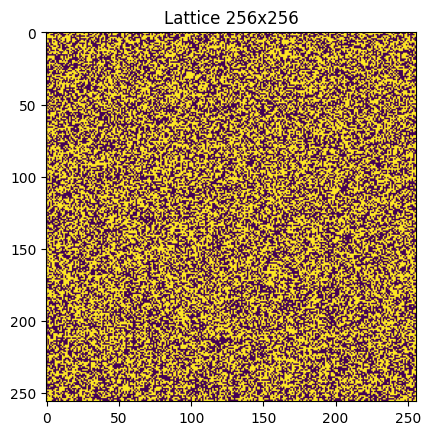

In [63]:
import matplotlib.pyplot as plt
import warp as wp

@wp.kernel
def generate_lattice(lattice: wp.array2d(dtype=wp.int8), rng_seed: int):
    """
    GPU kernel to initialize the lattice with random spin configurations.

    Each GPU thread handles one lattice site, generating a random spin value.

    Args:
        lattice: 2-D array to fill with random spins (+1 or -1)
        rng_seed: Seed for reproducible random number generation

    Kernel launch:
        wp.launch(generate_lattice, dim=(LATTICE_SIZE, LATTICE_SIZE), ...)
        Creates LATTICE_SIZE² threads, one per lattice site
    """
    
    # Get this thread's 2-D coordinates within the lattice
    # wp.tid() returns (i, j) where i∈[0,LATTICE_SIZE), j∈[0,LATTICE_SIZE)
    i, j = wp.tid()

    # Initialize random number generator state for this specific thread
    # - rng_seed: Shared across all threads for reproducible simulations
    # - offset: Unique per thread to ensure independent random sequences
    # - Linear indexing: thread (i,j) gets offset = i*width + j
    thread_offset = i * lattice.shape[1] + j
    rng_state = wp.rand_init(rng_seed, thread_offset)

    # Generate random spin value: +1 or -1 with equal probability
    # wp.randf() produces uniform random float in [0.0, 1.0)
    # 50% probability for each spin direction
    random_value = wp.randf(rng_state, 0.0, 1.0)
    if random_value < 0.5:
        lattice[i, j] = wp.int8(1)  # Spin up
    else:
        lattice[i, j] = wp.int8(-1)  # Spin down

# Define lattice dimensions - using 256x256 for demonstration
LATTICE_SIZE = 256

# Allocate GPU memory for the spin lattice
# wp.int8 stores values -1 and +1 efficiently (1 byte per spin)
# wp.empty() allocates uninitialized memory on the default device (GPU)
lattice = wp.empty((LATTICE_SIZE, LATTICE_SIZE), dtype=wp.int8)

# Launch the Warp kernel to initialize the lattice array
wp.launch(generate_lattice, lattice.shape, inputs=[lattice, 42])

fig = plt.figure()
plt.imshow(lattice.numpy(), cmap="viridis")
plt.title(f"Lattice {LATTICE_SIZE}x{LATTICE_SIZE}")
plt.show()

**Exercise for the reader:** In the cell above, change `LATTICE_SIZE` to each of the following values: $128, 64, 32, 16, 8$ and re-run the cell. For smaller `LATTICE_SIZES` of $16$ and $8$, can you verify visually that the random state is not changing unless you change the `rng_seed`?

### Implementing the Monte Carlo update kernel on GPU

Now we will implement the core of our GPU-accelerated Ising model simulation: a Warp kernel that performs the Metropolis-Hastings algorithm across the entire lattice in parallel.

#### Kernel input parameters

Our `update_lattice` kernel requires four key inputs:

1. **`lattice_in`**: The 2-D spin configuration array that serves as input
2. **`lattice_out`**: The 2-D spin configuration array that serves as output and will be modified in place
3. **`rng_seed`**: Random number seed for generating acceptance probabilities  
4. **`beta`**: Inverse temperature $\beta = 1/(k_B T)$, we assume $k_B = 1$

#### Parallel execution strategy

Each GPU thread will:
1. Calculate the energy change $\Delta E$ from flipping its assigned spin
2. Compute the acceptance ratio
3. Generate a random number and accept/reject the flip accordingly
4. Update the lattice site in **lattice_out** array

This approach allows us to evaluate $N^2$ spin flip proposals in parallel, achieving speedup over sequential CPU implementations that you will see in a bit.

In [ ]:
@wp.kernel
def update_lattice(
    beta: float,
    rng_seed: int,
    lattice_in: wp.array2d(dtype=wp.int8),
    lattice_out: wp.array2d(dtype=wp.int8),
):
    # Get the thread index
    i, j = wp.tid()

    # Dynamically obtain the lattice_size from either lattice_in or lattice_out array shape
    lattice_size = lattice_in.shape[0]
    
    # Neighbors: top, bottom, left, right
    nn_sum = (
        lattice_in[(i - 1 + lattice_size) % lattice_size, j]
        + lattice_in[(i + 1) % lattice_size, j]
        + lattice_in[i, (j - 1 + lattice_size) % lattice_size]
        + lattice_in[i, (j + 1) % lattice_size]
    )

    # Determine whether to flip spin
    # The acceptance ratio is calculated in the similar fashion as in the baseline implementation
    spin_ij = lattice_in[i, j]
    acceptance_ratio = wp.exp(-2.0 * beta * wp.float32(nn_sum) * wp.float32(spin_ij))

    # Generate a random number between [0.0, 1.0).
    rng_state = wp.rand_init(rng_seed, i * lattice_size + j)

    # Generate a random number between [0.0, 1.0) from the uniform distribution.
    # If random number < acceptance_ratio, accept the flip; otherwise reject.
    # If acceptance ratio is greater than 1, the energy has decreased and the spin flip will always be accepted.
    if wp.randf(rng_state, 0.0, 1.0) < acceptance_ratio:
        lattice_out[i, j] = -spin_ij
    else:
        lattice_out[i, j] = spin_ij

The `update_lattice(...)` kernel is called at the beginning of every Monte Carlo step. Once the kernel executes, `lattice_1` contains the updated state of spins. Right after the execution of the `update_lattice(...)` kernel, we swap `lattice_0` and `lattice_1` for the next Monte Carlo step. Hence, a single Monte Carlo step for the current GPU implementation would look something like this:

```python
# Execute update_lattice kernel to update all lattice sites in parallel
# lattice_1 contains the most updated lattice state
wp.launch(update_lattice, 
            dim=(lattice_size, lattice_size),
            inputs=[beta, random_seed, lattice_0, lattice_1])
    
# Swap lattice_1 and lattice_0 for next MC step
lattice_0, lattice_1 = lattice_1, lattice_0     
```

### First set of results

In the cell below, we put together all the building blocks from the previous cells. So let us examine the performance and behavior of our parallelization approach. 

The implementation we have created mirrors our earlier CPU-based Python version, with the key difference being the use of a buffer to avoid race conditions while trying to update spins on the lattice in parallel.

In [ ]:
%matplotlib widget

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import IPython.display

import os
import time

# --- Simulation Parameters ---
LATTICE_SIZE = 256
TEMPERATURE = 0.02  # Try: T=0.02 (ordered), T=2.269 (critical), T=20.0 (disordered)


# --- Warp related initializations/declarations ---
BETA = 1.0 / TEMPERATURE
lattice_0 = wp.empty((LATTICE_SIZE, LATTICE_SIZE), dtype=wp.int8)
lattice_1 = wp.empty((LATTICE_SIZE, LATTICE_SIZE), dtype=wp.int8)

wp.launch(generate_lattice, lattice_0.shape, inputs=[lattice_0, 42])

print(f"Simulating {LATTICE_SIZE}×{LATTICE_SIZE} Ising model at T={TEMPERATURE}")
print(
    f"Critical temperature T_c ≈ 2.269 (this run: {'below' if TEMPERATURE < 2.269 else 'above'} T_c)"
)

# Set up visualization colormap
# Viridis colormap: dark blue (-1 spins) to bright yellow (+1 spins)
viridis = plt.cm.viridis
norm = Normalize(vmin=-1, vmax=1)

# Collect animation frames
frames = []
print("Running simulation and capturing frames...")

start_time = time.perf_counter()
for step in range(200):  # 200 Monte Carlo steps
    # Warp kernel call that updates the lattice
    wp.launch(update_lattice, lattice_0.shape, inputs=[BETA, step, lattice_0, lattice_1])
    lattice_0, lattice_1 = lattice_1, lattice_0

    # Convert lattice to colored image for visualization
    # Each spin value (-1 or +1) gets mapped to a color
    colored_frame = viridis(norm(np.array(lattice_1.numpy())))

    # Convert to 8-bit RGB for GIF creation
    rgb_frame = (colored_frame[:, :, :3] * 255).astype(np.uint8)
    frames.append(rgb_frame)

    # Progress indicator
    if (step + 1) % 50 == 0:
        print(f"  Step {step + 1}/200 completed")

end_time = time.perf_counter()
print(f"Simulation completed in {end_time - start_time:.2f} seconds")

# Create animated GIF to visualize time evolution
print("Creating animated GIF...")
pil_images = [Image.fromarray(frame, mode="RGB") for frame in frames]
output_filename = f"./images/chapter-13/{LATTICE_SIZE}x{LATTICE_SIZE}_{TEMPERATURE}.gif"

# Ensure output directory exists
os.makedirs(os.path.dirname(output_filename), exist_ok=True)

# Save as animated GIF (100ms per frame = 10 FPS)
pil_images[0].save(
    output_filename,
    save_all=True,
    append_images=pil_images[1:],
    duration=100,  # milliseconds per frame
    loop=0,  # infinite loop
)

IPython.display.Image(output_filename)

#### Performance gains but unexpected results

Running the same lattice size and number of Monte Carlo steps as in the baseline Python implementation reveals significant performance improvements:

- **CPU implementation**: ~5.0 seconds for 200 Monte Carlo steps on a 256×256 lattice
- **GPU implementation**: ~0.2 seconds for the same workload

This represents a **25x speedup** - a significant improvement that demonstrates the power of GPU parallelization for this simulation. The acceleration comes from processing all 65,536 lattice sites in parallel rather than sequentially.

However, the results are not correct! At the low temperature $T = 0.02$, the 2-D Ising model should exhibit strong ferromagnetic ordering - we should see large domains of aligned spins with well-defined boundaries. Even at high temperatures, the results appear incorrect and differ significantly from our baseline Python implementation. This highlights the importance of maintaining a reference implementation when developing complex algorithms—it provides a reliable benchmark for validating correctness.

The lattice configuration appears unusually fragmented and disordered. This unexpected behavior suggests that our seemingly straightforward parallelization approach may have introduced subtle but significant algorithmic issues.

#### Investigating the discrepancy

The dramatic speedup is certainly encouraging, but the incorrect physics behavior indicates that raw performance gains mean nothing if the underlying algorithm produces wrong results. This observation leads us to an important question:

**What could be causing this discrepancy between expected and observed behavior? Try thinking about what could be the fundamental differences between the sequential Python implementation and the GPU implementation.**

In the next section, we will explore why our naive parallelization fails and introduce the checkerboard approach that correctly preserves the physics while maintaining GPU acceleration.


---

## GPU implementation part 2: Checkerboard approach

### Why did our parallel trick fail?

The problem with our double-buffered approach is that it breaks a core rule of the Metropolis algorithm: **the system must evolve sequentially**. Each update needs to depend on the result of the step that came right before it. This one-at-a-time process is what guarantees that the physics comes out right.

In our baseline sequential Python implementation, this rule is followed correctly -- when a spin at a randomly selected site was flipped, its four neighbors immediately saw the new value for any subsequent calculations. This ensures information flows through the lattice step-by-step.

The parallel double-buffered approach breaks this flow. Instead of using the most current information, it forces every spin update to be based on a single, old snapshot of the lattice taken at the beginning of the Monte Carlo step.

Because it lacks this essential sequential dependency, the double-buffered method is no longer running the Metropolis algorithm. It is executing a fundamentally different process, which is why it is fast but fails to produce the correct physical results.

### Checkerboard approach 

The algorithm described below takes care of this potential inconsistency during the update process within a single Monte Carlo step.

### Using a checkerboard update

This is a technique for handling computational problems with local dependencies on a grid.

The algorithm gets its name because we conceptually divide the lattice sites into two groups, like the
black and white squares on a chess board.

**Crucially, spins on black squares only have neighbors on white squares, and spins on white squares only have neighbors on black squares. Confirm it yourself in the image below.**

Instead of trying to update all lattice sites in one go (which, as we saw with the previous approach, can lead to spin updates not seeing each other's changes within the same MC update), we perform two distinct update substeps per Monte Carlo step:

1. **Update all "black" sites in parallel.** They read the current state of their "white" neighbors.
2. **Update all "white" sites in parallel.** They read the newly updated state of their "black" neighbors from step 1. 

The two-substep process ensures that when any spin is being updated, the neighbor values it reads are consistent and appropriate for that stage of the computation.

To give an example, the figure below shows a $4 \times 4$ lattice grid with each location being marked as `(unique_id, row_idx, col_idx)`. Here `unique_id` is the unique identification tied to the black/white lattice cell that will remain the same even after decomposing the lattice grid. On the other hand `row_idx, col_idx` correspond to row and column indices specific to the location of the element in the original or decomposed array.

<table style="border-collapse: collapse; text-align: center;">
  <tr>
    <td style="background-color: white; color: black; border: 1px solid black; padding: 10px;">(W0, 0, 0)</td>
    <td style="background-color: black; color: white; border: 1px solid black; padding: 10px;">(B0, 0, 1)</td>
    <td style="background-color: white; color: black; border: 1px solid black; padding: 10px;">(W1, 0, 2)</td>
    <td style="background-color: black; color: white; border: 1px solid black; padding: 10px;">(B1, 0, 3)</td>
  </tr>
  <tr>
    <td style="background-color: black; color: white; border: 1px solid black; padding: 10px;">(B2, 1, 0)</td>
    <td style="background-color: white; color: black; border: 1px solid black; padding: 10px;">(W2, 1, 1)</td>
    <td style="background-color: black; color: white; border: 1px solid black; padding: 10px;">(B3, 1, 2)</td>
    <td style="background-color: white; color: black; border: 1px solid black; padding: 10px;">(W3, 1, 3)</td>
  </tr>
  <tr>
    <td style="background-color: white; color: black; border: 1px solid black; padding: 10px;">(W4, 2, 0)</td>
    <td style="background-color: black; color: white; border: 1px solid black; padding: 10px;">(B4, 2, 1)</td>
    <td style="background-color: white; color: black; border: 1px solid black; padding: 10px;">(W5, 2, 2)</td>
    <td style="background-color: black; color: white; border: 1px solid black; padding: 10px;">(B5, 2, 3)</td>
  </tr>
  <tr>
    <td style="background-color: black; color: white; border: 1px solid black; padding: 10px;">(B6, 3, 0)</td>
    <td style="background-color: white; color: black; border: 1px solid black; padding: 10px;">(W6, 3, 1)</td>
    <td style="background-color: black; color: white; border: 1px solid black; padding: 10px;">(B7, 3, 2)</td>
    <td style="background-color: white; color: black; border: 1px solid black; padding: 10px;">(W7, 3, 3)</td>
  </tr>
</table>

Using the checkerboard pattern, we decompose this grid in two $4 \times 2$ grids each containing purely black and white spins. Once decomposed, the `row_idx, col_idx` of the different spins will change (shown below) while their `unique_id` will remain intact. Assigning an `unique_id` will help us in visualizing the checkerboard algorithm in a more intuitive fashion.

<div style="display: flex; gap: 5px; justify-content: left;">

<div>
<h4><b>Black Elements Table</b></h4>
<table style="border-collapse: collapse; text-align: center;">
  <tr>
    <td style="background-color: black; color: white; border: 1px solid black; padding: 10px;">(B0, 0, 0)</td>
    <td style="background-color: black; color: white; border: 1px solid black; padding: 10px;">(B1, 0, 1)</td>
  </tr>
  <tr>
    <td style="background-color: black; color: white; border: 1px solid black; padding: 10px;">(B2, 1, 0)</td>
    <td style="background-color: black; color: white; border: 1px solid black; padding: 10px;">(B3, 1, 1)</td>
  </tr>
  <tr>
    <td style="background-color: black; color: white; border: 1px solid black; padding: 10px;">(B4, 2, 0)</td>
    <td style="background-color: black; color: white; border: 1px solid black; padding: 10px;">(B5, 2, 1)</td>
  </tr>
  <tr>
    <td style="background-color: black; color: white; border: 1px solid black; padding: 10px;">(B6, 3, 0)</td>
    <td style="background-color: black; color: white; border: 1px solid black; padding: 10px;">(B7, 3, 1)</td>
  </tr>
</table>
</div>

<div>
<h4><b>White Elements Table</b></h4>
<table style="border-collapse: collapse; text-align: center;">
  <tr>
    <td style="background-color: white; color: black; border: 1px solid black; padding: 10px;">(W0, 0, 0)</td>
    <td style="background-color: white; color: black; border: 1px solid black; padding: 10px;">(W1, 0, 1)</td>
  </tr>
  <tr>
    <td style="background-color: white; color: black; border: 1px solid black; padding: 10px;">(W2, 1, 0)</td>
    <td style="background-color: white; color: black; border: 1px solid black; padding: 10px;">(W3, 1, 1)</td>
  </tr>
  <tr>
    <td style="background-color: white; color: black; border: 1px solid black; padding: 10px;">(W4, 2, 0)</td>
    <td style="background-color: white; color: black; border: 1px solid black; padding: 10px;">(W5, 2, 1)</td>
  </tr>
  <tr>
    <td style="background-color: white; color: black; border: 1px solid black; padding: 10px;">(W6, 3, 0)</td>
    <td style="background-color: white; color: black; border: 1px solid black; padding: 10px;">(W7, 3, 1)</td>
  </tr>
</table>
</div>

</div>




Now, we need to allocate separate arrays for the black and white populations.

They will be of size $N$ by $N/2$. We assume $N$ is even.

We will also allocate a $N$ by $N$ array for the combined lattice. This is not needed for the computation, but
it does help with visualization.

In [ ]:
import warp as wp

LATTICE_SIZE = 256

lattice_b = wp.empty((LATTICE_SIZE, LATTICE_SIZE // 2), dtype=wp.int8)
lattice_w = wp.empty_like(lattice_b)

# For plotting
combined_lattice = wp.empty((LATTICE_SIZE, LATTICE_SIZE), dtype=wp.int8)


# We can continue to use the following kernel from the previous cells
@wp.kernel
def generate_lattice(lattice: wp.array2d(dtype=wp.int8), rng_seed: int):
    i, j = wp.tid()

    # Generate random number between [0.0, 1.0).
    rng_state = wp.rand_init(rng_seed, i * lattice.shape[1] + j)

    # Pick 1 or -1 with equal probability
    if wp.randf(rng_state, 0.0, 1.0) < 0.5:
        lattice[i, j] = wp.int8(1)
    else:
        lattice[i, j] = wp.int8(-1)

We can use the following kernel to create the combined lattice from `lattice_b` and `lattice_w`:

In [ ]:
@wp.kernel
def combine_lattices(
    lattice_b: wp.array2d(dtype=wp.int8),
    lattice_w: wp.array2d(dtype=wp.int8),
    combined_lattice: wp.array2d(dtype=wp.int8),
):
    i, j = wp.tid()

    if (
        i % 2 == 0
    ):  # for even rows, white spins are at even indices and black spins are at odd indices
        combined_lattice[i, 2 * j] = lattice_w[i, j]
        combined_lattice[i, 2 * j + 1] = lattice_b[i, j]
    else:  # for odd rows, black spins are at even indices and white spins are at odd indices
        combined_lattice[i, 2 * j] = lattice_b[i, j]
        combined_lattice[i, 2 * j + 1] = lattice_w[i, j]

Let us see how it works. We will set all values of `lattice_w` to 1 and all values of `lattice_b` to -1, and then we will combine the two arrays by running the `combine_lattices` kernel.

In [ ]:
%matplotlib widget

import matplotlib.pyplot as plt

lattice_w.fill_(1)
lattice_b.fill_(-1)

wp.launch(
    combine_lattices,
    dim=lattice_b.shape,
    inputs=[lattice_b, lattice_w, combined_lattice],
)

fig = plt.figure()
plt.imshow(combined_lattice.numpy(), cmap="viridis")
plt.title(f"Lattice {LATTICE_SIZE}x{LATTICE_SIZE}")
plt.show()

### Checkerboard neighbor indexing logic

When we decompose our $N×N$ lattice into two $N×(N/2)$ sublattices (black and white), finding horizontal neighbors becomes a bit more complex. Finding top and bottom neighbors is still relatively straightforward (we just need to keep wrapping around the corners for periodic boundary conditions).

Each cell in a decomposed sublattice has **two horizontal neighbors** in the opposite colored sublattice:
- A **left neighbor** 
- A **right neighbor**

The indexing pattern depends on:
1. **Which sublattice** we are updating (black or white)
2. **Row parity** (even or odd row index)


For any position `[i,j]` in a sublattice, we need these two helper indices:
```python
sub_col_left_idx = (j - 1 + N//2) % (N//2)   # Left neighbor column (with wrapping)
sub_col_right_idx = (j + 1) % (N//2)         # Right neighbor column (with wrapping)
```

#### Case 1: Updating Black[i,j]

| Row Type | Left Neighbor | Right Neighbor |
|----------|---------------|----------------|
| **Even row** (i % 2 == 0) | `W[i, j]` | `W[i, sub_col_right_idx]` |
| **Odd row** (i % 2 == 1) | `W[i, sub_col_left_idx]` | `W[i, j]` |

#### Case 2: Updating White[i,j]

| Row Type | Left Neighbor | Right Neighbor |
|----------|---------------|----------------|
| **Even row** (i % 2 == 0) | `B[i, sub_col_left_idx]` | `B[i, j]` |
| **Odd row** (i % 2 == 1) | `B[i, j]` | `B[i, sub_col_right_idx]` |

#### Verify the above two cases in the figures below

<table style="border-collapse: collapse; text-align: center;">
  <tr>
    <td style="background-color: white; color: black; border: 1px solid black; padding: 10px;">(W0, 0, 0)</td>
    <td style="background-color: black; color: white; border: 1px solid black; padding: 10px;">(B0, 0, 1)</td>
    <td style="background-color: white; color: black; border: 1px solid black; padding: 10px;">(W1, 0, 2)</td>
    <td style="background-color: black; color: white; border: 1px solid black; padding: 10px;">(B1, 0, 3)</td>
  </tr>
  <tr>
    <td style="background-color: black; color: white; border: 1px solid black; padding: 10px;">(B2, 1, 0)</td>
    <td style="background-color: white; color: black; border: 1px solid black; padding: 10px;">(W2, 1, 1)</td>
    <td style="background-color: black; color: white; border: 1px solid black; padding: 10px;">(B3, 1, 2)</td>
    <td style="background-color: white; color: black; border: 1px solid black; padding: 10px;">(W3, 1, 3)</td>
  </tr>
  <tr>
    <td style="background-color: white; color: black; border: 1px solid black; padding: 10px;">(W4, 2, 0)</td>
    <td style="background-color: black; color: white; border: 1px solid black; padding: 10px;">(B4, 2, 1)</td>
    <td style="background-color: white; color: black; border: 1px solid black; padding: 10px;">(W5, 2, 2)</td>
    <td style="background-color: black; color: white; border: 1px solid black; padding: 10px;">(B5, 2, 3)</td>
  </tr>
  <tr>
    <td style="background-color: black; color: white; border: 1px solid black; padding: 10px;">(B6, 3, 0)</td>
    <td style="background-color: white; color: black; border: 1px solid black; padding: 10px;">(W6, 3, 1)</td>
    <td style="background-color: black; color: white; border: 1px solid black; padding: 10px;">(B7, 3, 2)</td>
    <td style="background-color: white; color: black; border: 1px solid black; padding: 10px;">(W7, 3, 3)</td>
  </tr>
</table>

<div style="display: flex; gap: 5px; justify-content: left;">

<div>
<h4><b>Black Elements Table</b></h4>
<table style="border-collapse: collapse; text-align: center;">
  <tr>
    <td style="background-color: black; color: white; border: 1px solid black; padding: 10px;">(B0, 0, 0)</td>
    <td style="background-color: black; color: white; border: 1px solid black; padding: 10px;">(B1, 0, 1)</td>
  </tr>
  <tr>
    <td style="background-color: black; color: white; border: 1px solid black; padding: 10px;">(B2, 1, 0)</td>
    <td style="background-color: black; color: white; border: 1px solid black; padding: 10px;">(B3, 1, 1)</td>
  </tr>
  <tr>
    <td style="background-color: black; color: white; border: 1px solid black; padding: 10px;">(B4, 2, 0)</td>
    <td style="background-color: black; color: white; border: 1px solid black; padding: 10px;">(B5, 2, 1)</td>
  </tr>
  <tr>
    <td style="background-color: black; color: white; border: 1px solid black; padding: 10px;">(B6, 3, 0)</td>
    <td style="background-color: black; color: white; border: 1px solid black; padding: 10px;">(B7, 3, 1)</td>
  </tr>
</table>
</div>

<div>
<h4><b>White Elements Table</b></h4>
<table style="border-collapse: collapse; text-align: center;">
  <tr>
    <td style="background-color: white; color: black; border: 1px solid black; padding: 10px;">(W0, 0, 0)</td>
    <td style="background-color: white; color: black; border: 1px solid black; padding: 10px;">(W1, 0, 1)</td>
  </tr>
  <tr>
    <td style="background-color: white; color: black; border: 1px solid black; padding: 10px;">(W2, 1, 0)</td>
    <td style="background-color: white; color: black; border: 1px solid black; padding: 10px;">(W3, 1, 1)</td>
  </tr>
  <tr>
    <td style="background-color: white; color: black; border: 1px solid black; padding: 10px;">(W4, 2, 0)</td>
    <td style="background-color: white; color: black; border: 1px solid black; padding: 10px;">(W5, 2, 1)</td>
  </tr>
  <tr>
    <td style="background-color: white; color: black; border: 1px solid black; padding: 10px;">(W6, 3, 0)</td>
    <td style="background-color: white; color: black; border: 1px solid black; padding: 10px;">(W7, 3, 1)</td>
  </tr>
</table>
</div>

</div>

#### Example: Finding neighbors of B2 and W5 in the decomposed sublattices

For `(B2, 1, 0)` in the decomposed grid (row 1 is odd):
- `j = 0`, so:
  - `sub_col_left_idx = (0-1+2) % 2 = 1`
  - `sub_col_right_idx = (0+1) % 2 = 1`
- **Left neighbor**: `W3` = `White[1, sub_col_left_idx]` = `White[1,1]`
- **Right neighbor**: `W2` = `White[1, j]` = `White[1,0]`
- **Up neighbor**: `W0` = `White[(i - 1 + N) % N, j]` = `White[0,0]`
- **Down neighbor**: `W4` = `White[(i + 1) % N, j]` = `White[2,0]`


For `(W5, 2, 1)` in the decomposed grid (row 2 is even):
- `j = 1`, so:
  - `sub_col_left_idx = (1-1+2) % 2 = 0`
  - `sub_col_right_idx = (1+1) % 2 = 0`
- **Left neighbor**: `B4` = `Black[2, sub_col_left_idx]` = `Black[2,0]`
- **Right neighbor**: `B5` = `Black[2, j]` = `Black[2,1]`
- **Up neighbor**: `B3` = `Black[(i - 1 + N) % N, j]` = `Black[1,1]`
- **Down neighbor**: `B7` = `Black[(i + 1) % N, j]` = `Black[3,1]`

In [ ]:
@wp.kernel
def update_lattice(
    beta: float,  # Inverse temperature parameter (β = 1/kT)
    rng_seed: int,  # Random seed for Monte Carlo sampling
    is_black: bool,  # True if updating black sublattice, False for white
    op_lattice: wp.array2d(dtype=wp.int8),  # Opposite color sublattice (N × N/2)
    lattice: wp.array2d(
        dtype=wp.int8
    ),  # Current color sublattice being updated (N × N/2)
):

    # Get thread coordinates in the current sublattice
    i, j = wp.tid()

    lattice_size = lattice.shape[0]  # N (number of rows)
    num_sub_cols = lattice_size // 2  # N/2 (columns per sublattice)

    # Helper indices for horizontal neighbors (with periodic boundary conditions)
    sub_col_left_idx = (j - 1 + num_sub_cols) % num_sub_cols
    sub_col_right_idx = (j + 1) % num_sub_cols

    # Determine which column index to use for the "second" horizontal neighbor
    # op_lattice[i, j] is always the "first" horizontal neighbor due to checkerboard mapping

    if is_black:
        # Current spin is B[i, j]
        # op_lattice is W
        if i % 2 == 0:
            # B is at global (i, 2*j + 1)
            # Horizontal W neighbors are W[i, j] (global left)
            # and W[i, sub_col_right_idx] (global right)
            second_horizontal_neighbor_sub_col_idx = sub_col_right_idx
        else:
            # B is at global (i, 2*j)
            # Horizontal W neighbors are W[i, sub_col_left_idx] (global left)
            # and W[i, j] (global right)
            second_horizontal_neighbor_sub_col_idx = sub_col_left_idx
    else:
        # Current spin is W[i, j]
        # op_lattice is B
        if i % 2 == 0:
            # W is at global (i, 2*j)
            # Horizontal B neighbors are B[i, sub_col_left_idx] (global left)
            # and B[i, j] (global right)
            second_horizontal_neighbor_sub_col_idx = sub_col_left_idx
        else:
            # W is at global (i, 2*j + 1)
            # Horizontal B neighbors are B[i, j] (global left)
            # and B[i, sub_col_right_idx] (global right)
            second_horizontal_neighbor_sub_col_idx = sub_col_right_idx

    nn_sum = (
        op_lattice[(i - 1 + lattice_size) % lattice_size, j]  # Top neighbor
        + op_lattice[(i + 1) % lattice_size, j]  # Bottom neighbor
        + op_lattice[i, j]  # First horizontal neighbor
        + op_lattice[
            i, second_horizontal_neighbor_sub_col_idx
        ]  # Second horizontal neighbor
    )

    spin_ij = lattice[i, j]  # Current spin value (+1 or -1)

    acceptance_ratio = wp.exp(-2.0 * beta * wp.float32(nn_sum) * wp.float32(spin_ij))

    rng_state = wp.rand_init(rng_seed, i * num_sub_cols + j)
    random_value = wp.randf(rng_state, 0.0, 1.0)

    if random_value < acceptance_ratio:
        lattice[i, j] = -spin_ij

Let us run and benchmark the checkerboard algorithm. The code snippet below is similar to the one for baseline Python implementation except for lattice updates being done using Warp.

In [ ]:
import numpy as np
import time
import os
import IPython.display
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# --- Simulation Parameters ---
TEMPERATURE = (
    0.02  # Try other temperatures: T_low = 0.02 (ordered), T_high = 20.0 (disordered)
)
BETA = 1.0 / TEMPERATURE
LATTICE_SIZE = 256

lattice_b = wp.empty((LATTICE_SIZE, LATTICE_SIZE // 2), dtype=wp.int8)
lattice_w = wp.empty_like(lattice_b)
combined_lattice = wp.empty((LATTICE_SIZE, LATTICE_SIZE), dtype=wp.int8)

print(f"Simulating {LATTICE_SIZE}×{LATTICE_SIZE} Ising model at T={TEMPERATURE}")
print(
    f"Critical temperature T_c ≈ 2.269 (this run: {'below' if TEMPERATURE < 2.269 else 'above'} T_c)"
)


# Reset initial conditions
wp.launch(generate_lattice, lattice_b.shape, inputs=[lattice_b, 17])
wp.launch(generate_lattice, lattice_w.shape, inputs=[lattice_w, 42])

# Get viridis colormap
viridis = plt.cm.viridis
norm = Normalize(vmin=-1, vmax=1)

# Collect animation frames
frames = []
print("Running simulation and capturing frames...")

start_time = time.time()
for i in range(200):
    # Update black (is_black=True)
    wp.launch(
        update_lattice,
        (LATTICE_SIZE, LATTICE_SIZE // 2),
        inputs=[BETA, i + 17, True, lattice_w, lattice_b],
    )
    # Update white (is_black=False)
    wp.launch(
        update_lattice,
        (LATTICE_SIZE, LATTICE_SIZE // 2),
        inputs=[BETA, i + 42, False, lattice_b, lattice_w],
    )

    # Combine the lattices
    wp.launch(
        combine_lattices,
        dim=lattice_b.shape,
        inputs=[lattice_b, lattice_w, combined_lattice],
    )

    # Copy to CPU and apply colormap
    normalized_lattice = norm(combined_lattice.numpy())
    colored_frame = viridis(normalized_lattice)

    # Convert to RGB
    rgb_frame = (colored_frame[:, :, :3] * 255).astype(np.uint8)
    frames.append(rgb_frame)

    if (i + 1) % 50 == 0:
        print(f"  Step {i + 1}/200 completed")

print(f"Total time taken: {time.time() - start_time} seconds")

# Create animated GIF to visualize time evolution
print("Creating animated GIF...")
pil_images = [Image.fromarray(frame, mode="RGB") for frame in frames]
output_filename = f"./images/chapter-13/{LATTICE_SIZE}x{LATTICE_SIZE}_{TEMPERATURE}.gif"

# Ensure output directory exists
os.makedirs(os.path.dirname(output_filename), exist_ok=True)

# Save as animated GIF (100ms per frame = 10 FPS)
pil_images[0].save(
    output_filename,
    save_all=True,
    append_images=pil_images[1:],
    duration=100,  # milliseconds per frame
    loop=0,  # infinite loop
)

IPython.display.Image(output_filename)

The code still runs almost ~$25\times$ faster than the basic Python implementation in the beginning of the notebook. This is despite an extra kernel call to combine black/white lattice grids and black/white lattice updates being done sequentially.  

---
## Comparison with analytical solution

Finally, we can write some code that plots the steady-state absolute value of magnetization across a range of temperatures.

For $T < T_{\mathrm{crit}}$, there is actually an analytic solution discovered by Onsager in 1944 for the spontaneous magnetization of a 2-D Ising model in zero external magnetic field for temperatures below the critical temperature.

\begin{align}
    M = \left[1 - \frac{1}{\left(\sinh \left( \frac{2 J}{k_B T} \right) \right)^4}\right]^{1/8}
\end{align}

For $T > T_c$, the system is in a paramagnetic state with no net magnetization ($M = 0$).

In [ ]:
@wp.kernel
def compute_total_magnetization(
    lattice_b: wp.array2d(dtype=wp.int8),
    lattice_w: wp.array2d(dtype=wp.int8),
    result: wp.array(dtype=wp.int32),
):
    i, j = wp.tid()
    # Sum up spins at idx (i, j) in both black and white sublattices
    local_val = wp.int32(lattice_b[i, j] + lattice_w[i, j])
    # Add local value to the result array
    wp.atomic_add(result, 0, local_val)

In [ ]:
import statistics
import numpy as np


def calculate_steady_state_magnetization(temperature):
    BETA = 1.0 / temperature

    # Also allocate memory for total magnetization
    magnetization_values = []
    total_magnetization = wp.zeros(1, dtype=wp.int32)

    # Reset initial conditions
    wp.launch(generate_lattice, lattice_b.shape, inputs=[lattice_b, 17])
    wp.launch(generate_lattice, lattice_w.shape, inputs=[lattice_w, 42])

    # Warmup
    for step in range(3000):
        # Update black (is_black=True)
        wp.launch(
            update_lattice,
            (LATTICE_SIZE, LATTICE_SIZE // 2),
            inputs=[BETA, step + 17, True, lattice_w, lattice_b],
        )
        # Update white (is_black=False)
        wp.launch(
            update_lattice,
            (LATTICE_SIZE, LATTICE_SIZE // 2),
            inputs=[BETA, step + 42, False, lattice_b, lattice_w],
        )

    for step in range(1000):
        # Update black (is_black=True)
        wp.launch(
            update_lattice,
            (LATTICE_SIZE, LATTICE_SIZE // 2),
            inputs=[BETA, step + 17, True, lattice_w, lattice_b],
        )
        # Update white (is_black=False)
        wp.launch(
            update_lattice,
            (LATTICE_SIZE, LATTICE_SIZE // 2),
            inputs=[BETA, step + 42, False, lattice_b, lattice_w],
        )

        # Compute total magnetization
        total_magnetization.zero_()
        wp.launch(
            compute_total_magnetization,
            lattice_b.shape,
            inputs=[lattice_b, lattice_w, total_magnetization],
        )

        # Append average magnetization to a Python list
        magnetization_values.append(
            abs(total_magnetization.numpy()[0]) / (LATTICE_SIZE * LATTICE_SIZE)
        )

    return statistics.mean(magnetization_values), statistics.stdev(magnetization_values)


# Recall that the critical temperature is 2.269
temperatures = [1.4, 1.6, 1.8, 2.0, 2.1, 2.15, 2.2, 2.25, 2.3, 2.4, 2.5, 2.7, 3.0]
magnetization_values = []
magnetization_stdev_values = []
for temperature in temperatures:
    m, m_stdev = calculate_steady_state_magnetization(temperature)

    magnetization_values.append(m)
    magnetization_stdev_values.append(m_stdev)

# Plot result
fig, ax = plt.subplots(figsize=(10, 6))

plt.errorbar(
    temperatures,
    magnetization_values,
    yerr=magnetization_stdev_values,
    fmt="o--",
    capsize=5,
    capthick=2,
    label="Simulation ± σ",
    color="#76b900",
)

# Add Onsager solution
T_crit = 2 / np.log(1 + np.sqrt(2))
T_theory = np.linspace(temperatures[0], T_crit * 0.999, 500)
M_onsager = (1 - np.sinh(2 / T_theory) ** (-4)) ** (1 / 8)

plt.plot(
    T_theory, M_onsager, "-", linewidth=2, label="Onsager Solution", color="#7209B7"
)
plt.axvline(T_crit, color="black", linestyle="--", label=f"T_c = {T_crit:.3f}")
plt.legend()

ax.set_xlabel("Temperature (T)", fontsize=12)
ax.set_ylabel("Magnetization (M)", fontsize=12)
ax.set_title("Magnetization vs. Temperature", fontsize=14)
ax.grid(True, alpha=0.3)
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.canvas.resizable = False

plt.tight_layout()

---
## Conclusion

In this notebook, we examined different attempts to simulate the Ising model in two dimensions.

The main intention behind this exercise was to illuminate some considerations when writing algorithms that run **correctly** and **efficiently** on a GPU.

Starting from a sequential Python version, we encountered a fundamental challenge: while separating the lattice into "current" and "updated" grids eliminates race conditions, this approach inadvertently alters the underlying physics, producing an algorithm that no longer faithfully reproduces the statistical mechanics of the original sequential implementation.

Finally, we saw that a checkerboard algorithm allows us to recover the intended physics while addressing the data dependency issues that hindered the initial approaches.

---
## References

You can find the Warp GitHub repository and documentation below:
* "NVIDIA/warp: A Python framework for accelerated simulation, data generation and spatial computing.", GitHub, https://github.com/NVIDIA/warp.
* Warp Developers, "NVIDIA Warp Documentation," GitHub Pages, https://nvidia.github.io/warp.

Note: This tutorial was inspired by [Romero et al.'s](https://www.sciencedirect.com/science/article/abs/pii/S0010465520302228) work on implementation of 2-D Ising model on GPUs.

